In [151]:
import torch
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from source.policy import Policy
from source.critic import Critic
from source.memory import Memory
from source.environment import Environment, EnvironmentParameters
from utils.miscellaneous import load_best_model

### Load model and environment
- Episode options
  - episode length of apprx. 1 year i.e. 8760 hrs
  - episode leangth of 3 days       i.e. 72 hrs
- Model options
  - heuristic best model
  - shac

In [152]:
torch.manual_seed(42)

env_params       = EnvironmentParameters
prices, max_step = Environment.load_prices(env_params.price_prediction_horizon)

episode_length = int(len(prices) / 3)  # ~1 year
#episode_length = 72  # 3 days

initial_step   = 0

env = Environment(env_params, prices, initial_step, max_step)

policy = Policy()
critic = Critic()
#load_best_model("./models/shac_best_model_3000_6_32.pt", policy, critic)
#load_best_model("./models/shac_last_model_3000_6_32.pt", policy, critic)
#load_best_model("./models/shac_last_model_20000_6_32.pt", policy, critic)
#load_best_model("./models/shac_last_model_10000_6_32.pt", policy, critic)
#load_best_model("./models/shac_last_model_5990_6_32.pt", policy, critic)
load_best_model("./models/shac_best_model_2hrsb4_last_10000_6_32.pt", policy, critic)

policy.eval()
critic.eval()

tmpObs     = env.get_observation()
len_obs    = len(tmpObs)
len_action = len(policy(tmpObs)[0])
memory = Memory(1, episode_length, len_obs, len_action)

env.clear_gradients()
observation = env.get_observation()

for istep in range(episode_length):
    action = policy(observation)
    next_obs, reward, penalty = env.step(action[0])
    memory.store(0, istep, observation, next_obs, action, reward, penalty)
    observation = next_obs

Extract data from memory

In [153]:
rewards      = memory.rewards.detach().squeeze()
penalties    = memory.penalties.detach().squeeze()
observations = memory.observations.detach().squeeze()
actions      = memory.actions.detach().squeeze()

Calculate relative cost savings

Relative cost savings: 9.43 %


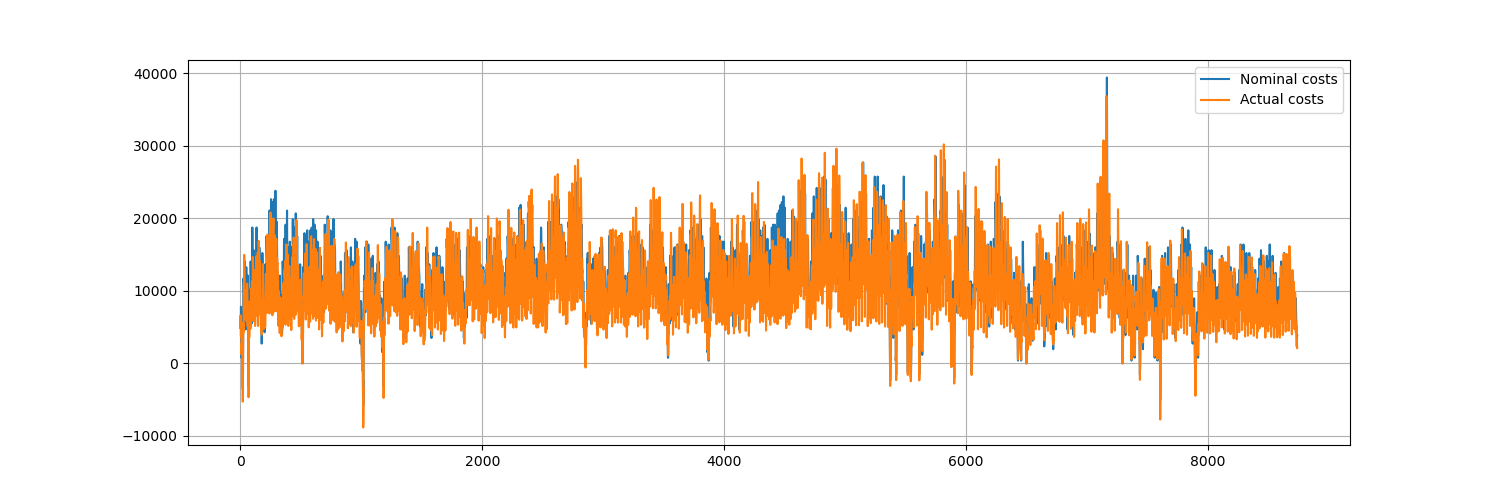

In [154]:
nominal_costs = env.params.nominal_coolant_flow_rate * env.prices[:episode_length] * env.params.delta_t
actual_costs  = actions[:, 1] * env.prices[:episode_length] * env.params.delta_t

total_nominal_costs = nominal_costs.sum()
total_actual_costs  = actual_costs.sum()

relative_cost_savings = (total_nominal_costs - total_actual_costs) / total_nominal_costs
print(f"Relative cost savings: {100 * relative_cost_savings:>.2f} %")
#relative_cost_savings = total_actual_costs / total_nominal_costs
#print(f"Relative cost savings: {relative_cost_savings:>.4f}")

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(nominal_costs)
ax.plot(actual_costs)
ax.legend(['Nominal costs', 'Actual costs'])
plt.show()

Analyze constraints for states and storage

Average storage level: 1.3996


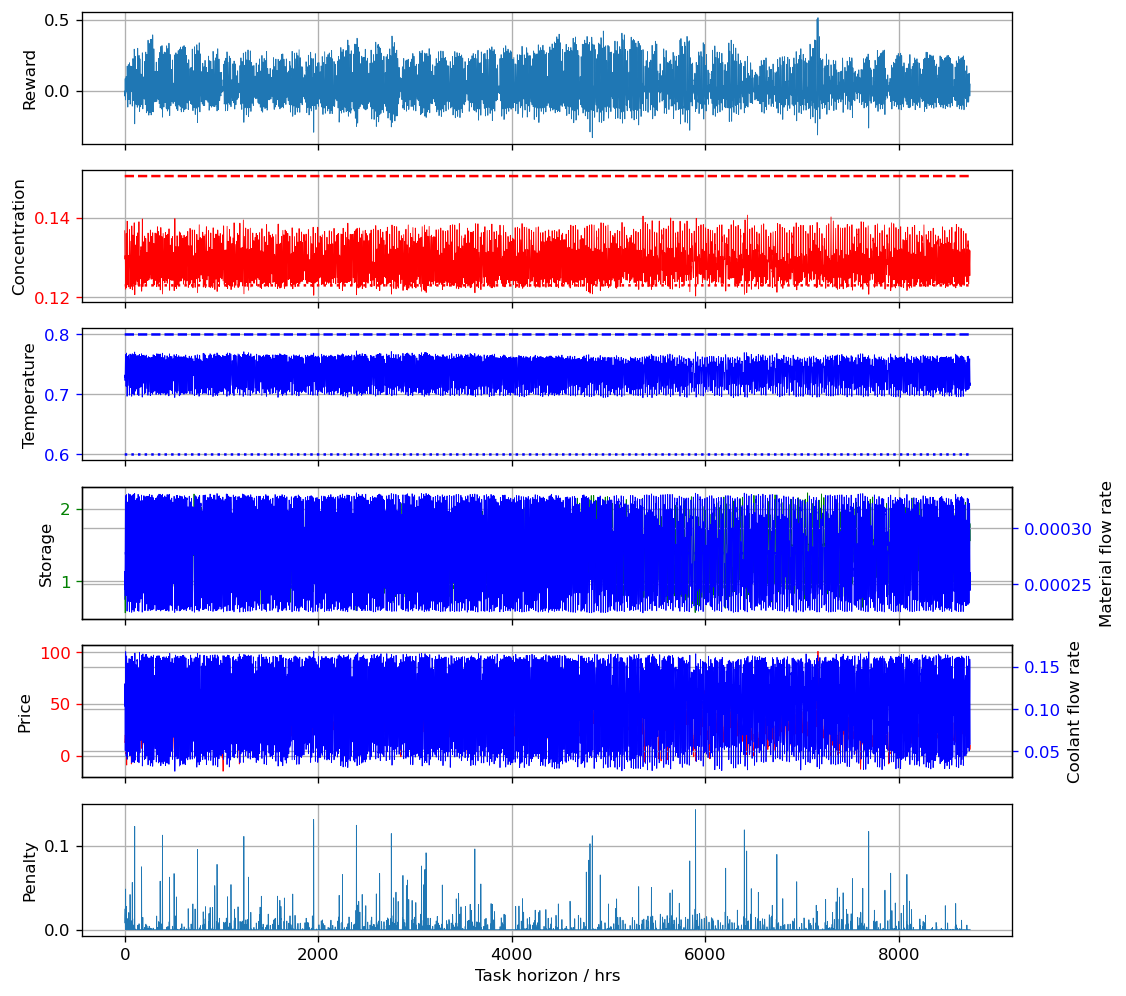

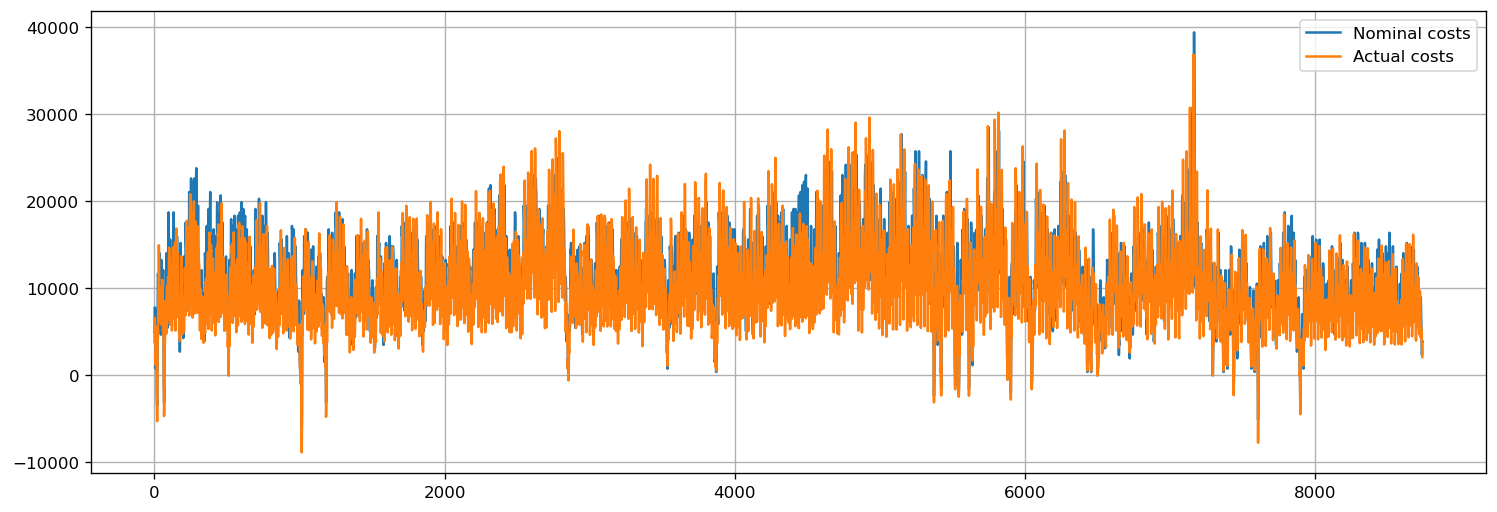

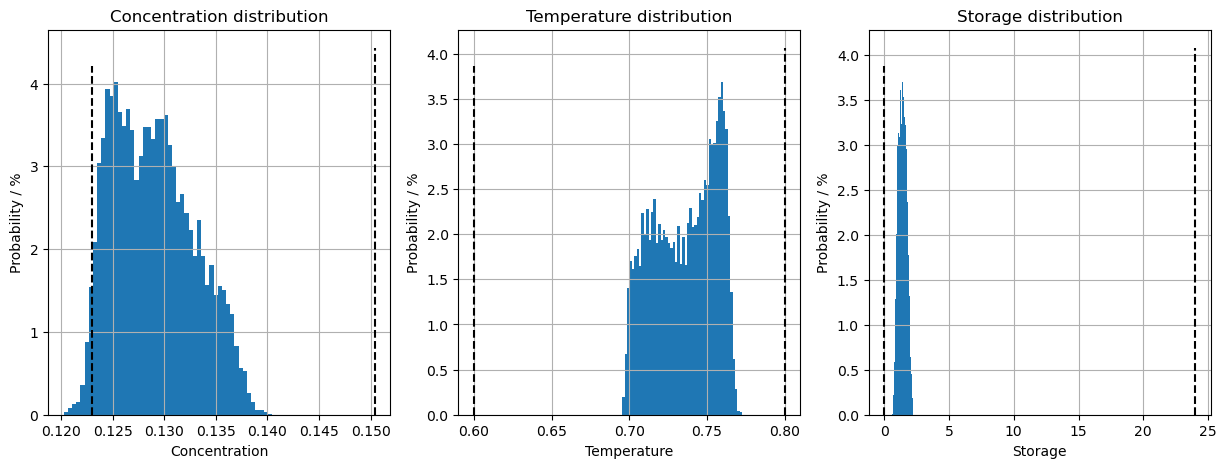

In [155]:
%matplotlib inline

concentration = observations[:, 0]
temperature  = observations[:, 1]
storage      = observations[:, 2]

print(f"Average storage level: {torch.mean(storage):>.4f}")

weights = 100 * np.ones_like(storage) / len(storage)  # to plot probability

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(concentration, 50, weights=weights)
ax[0].plot(np.repeat(env.min_state[0], 2), np.array([0, ax[0].get_ylim()[1]]), 'k--')
ax[0].plot(np.repeat(env.max_state[0], 2), np.array([0, ax[0].get_ylim()[1]]), 'k--')
ax[0].set_title('Concentration distribution')
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Probability / %')

ax[1].hist(temperature, 50, weights=weights)
ax[1].plot(np.repeat(env.min_state[1], 2), np.array([0, ax[1].get_ylim()[1]]), 'k--')
ax[1].plot(np.repeat(env.max_state[1], 2), np.array([0, ax[1].get_ylim()[1]]), 'k--')
ax[1].set_title('Temperature distribution')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel('Probability / %')

ax[2].hist(storage, 50, weights=weights)
ax[2].plot(np.repeat(env.min_storage, 2), np.array([0, ax[2].get_ylim()[1]]), 'k--')
ax[2].plot(np.repeat(env.max_storage, 2), np.array([0, ax[2].get_ylim()[1]]), 'k--')
ax[2].set_title('Storage distribution')
ax[2].set_xlabel('Storage')
ax[2].set_ylabel('Probability / %')

plt.show()


Calculate violation occurances

In [156]:
violation_probability = (penalties > 0).sum() / len(penalties) #episode length
print(f"Penalties occured {100 * violation_probability:>.2f} % of the time.")

No such comm: ea73a325174644fea9df1454bf9a94a6


Penalties occured 14.27 % of the time.


Calculate violation area

In [157]:
# Calculate the area under the curve
area_under_curve = np.trapz(penalties.numpy(), np.arange(len(penalties)))
print(f"Area under the penalty curve: {area_under_curve}")
print(len(penalties))

Area under the penalty curve: 12.896389365141772
8738


In [158]:
penalties_numpy = penalties.numpy()
x = np.arange(len(penalties_numpy))
# Calculate the area under the curve
area_under_curve = np.trapz(penalties_numpy, x)
print(f"Area under the penalty curve: {area_under_curve}")
print(len(penalties_numpy))

Area under the penalty curve: 12.896389365141772
8738


### Plot the control behavior

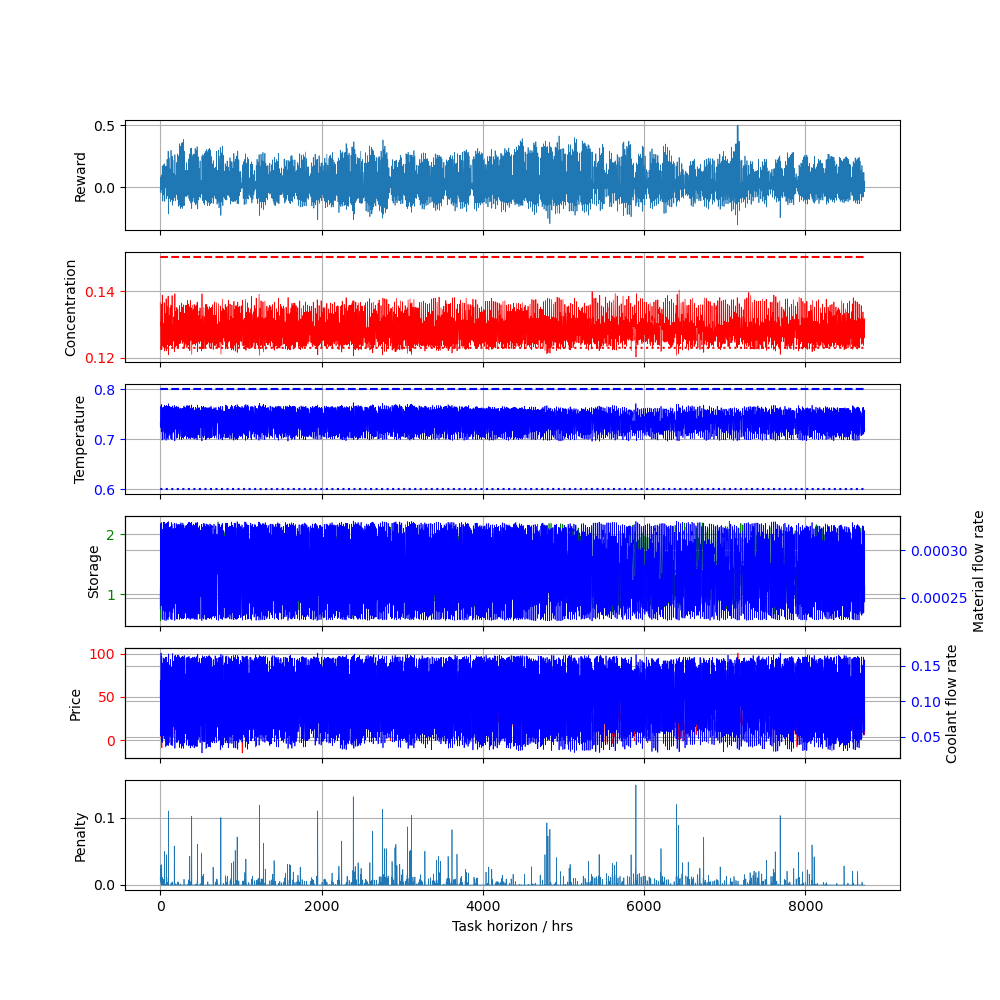

In [159]:
%matplotlib widget
mpl.rcParams.update({"axes.grid" : True})

max_states = np.tile(env.max_state, (episode_length,1))
min_states = np.tile(env.min_state, (episode_length,1))
state_colors = ['r', 'b']
linewidth = 0.5

fig, ax = plt.subplots(6, 1, sharex=True, figsize=(10, 10))

ax[0].plot(rewards, linewidth=linewidth)
ax[0].set_ylabel(f'Reward')

ax[1].plot(concentration, color=state_colors[0], linewidth=linewidth)
ax[1].plot(max_states[:, 0], '--', color=state_colors[0])
ax[1].plot(min_states[:, 0], ':', color=state_colors[0])
ax[1].set_ylabel(f'Concentration')

ax[2].plot(temperature, color=state_colors[1], linewidth=linewidth)
ax[2].plot(max_states[:, 1], '--', color=state_colors[1])
ax[2].plot(min_states[:, 1], ':', color=state_colors[1])
ax[2].set_ylabel(f'Temperature')

ax[3].plot(storage, color='g', linewidth=linewidth)
ax3 = ax[3].twinx()
ax3.plot(actions[:, 0], color='b', linewidth=linewidth, label='roh')
ax3.plot(np.tile(env.params.nominal_production_rate, (episode_length,1)), 'b:',  label='rho_nom')
ax[3].set_ylabel(f'Storage')
ax3.set_ylabel(f'Material flow rate')

ax[4].plot(prices[:episode_length], color='r', linewidth=linewidth)
ax4 = ax[4].twinx()
ax4.plot(actions[:, 1], color='b', linewidth=linewidth, label='F_c')
ax4.plot(np.tile(env.params.nominal_coolant_flow_rate, (episode_length,1)), 'b:', label='F_c_nom')
ax[4].set_ylabel(f'Price')
ax4.set_ylabel(f'Coolant flow rate')

ax[5].plot(penalties, linewidth=linewidth)
ax[5].set_xlabel(f'Task horizon / hrs')
ax[5].set_ylabel(f'Penalty')



# ax[1].spines['left'].set_color('r')  
# ax[2].spines['left'].set_color('b')
# ax[3].spines['left'].set_color('g')
# ax[4].spines['left'].set_color('r')
# ax3.spines['right'].set_color('b')
# ax4.spines['right'].set_color('b')
# ax3.spines['left'].set_color('g')
# ax4.spines['left'].set_color('r')


ax[1].tick_params(axis='y', colors='r')
ax[2].tick_params(axis='y', colors='b')
ax[3].tick_params(axis='y', colors='g')
ax[4].tick_params(axis='y', colors='r')
ax3.tick_params(axis='y', colors='b')
ax4.tick_params(axis='y', colors='b')


#ax[5].set_yscale('log')
# ax[1].legend(['c', 'c_max', 'c_min'])
# ax[2].legend(['T', 'T_max', 'T_min'])
# ax[3].legend(['storage_level'])
# ax[4].legend(['electricity_prices'])
# ax3.legend()
# ax4.legend()

plt.show()

In [160]:
print(f"Relative cost savings: {100 * relative_cost_savings:>.2f} %")
print(f"Penalties occurance  : {100 * violation_probability:>.2f} %")
print(f"Penalties area  : {area_under_curve:>.4f}")
print(f"Average contraint violation size : {area_under_curve/len(penalties):>.4f}")
print(f"Average storage level: {torch.mean(storage):>.4f}")


Relative cost savings: 9.43 %
Penalties occurance  : 14.27 %
Penalties area  : 12.8964
Average contraint violation size : 0.0015
Average storage level: 1.3996
